0. Getting embeddings
1. K-Means clustering
2. DBSCAN clustering

# 0. Getting embeddings

In [1]:
import types

import torch
import torch.nn as nn

import torchvision
from torchvision import datasets
from torchsummary import summary

from extract_patches import *
from pytorch_utils import *

%load_ext autoreload
%autoreload 2

In [2]:
debug_vals = types.SimpleNamespace()

####  Load data

In [3]:
img_name = 'ESP_011261_1960_RED0_0.IMG'
images, ids = extract_patches_from_img(img_name, patch_size=256)

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\PIL\Image.py:2618: DecompressionBombWarning: Image size (102400000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [4]:
tensor_images = numpy_images_to_tensor_dataset(images)

In [5]:
try:
    # we need it because of cuda bug:
    # https://github.com/pytorch/pytorch/issues/17108
    _ = torch.cuda.current_device()
except:
    pass

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

####  Load saved Model (only encoding part)

In [6]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    

In [7]:
class ConvAutoencoderV2(nn.Module):
    def __init__(self, image_channels=1):
        super(ConvAutoencoderV2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 5, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            
            nn.Conv2d(5, 10, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            
            nn.Conv2d(10, 15, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            
            nn.Conv2d(15, 20, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            
            nn.Conv2d(20, 25, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            
            Flatten(),
        )


    def forward(self, x):
        x = self.encoder(x)
        
        return x

model = ConvAutoencoderV2().to(device)
summary(ConvAutoencoderV2().to(device), (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 5, 128, 128]             130
         LeakyReLU-2          [-1, 5, 128, 128]               0
            Conv2d-3           [-1, 10, 64, 64]           1,260
         LeakyReLU-4           [-1, 10, 64, 64]               0
            Conv2d-5           [-1, 15, 32, 32]           3,765
         LeakyReLU-6           [-1, 15, 32, 32]               0
            Conv2d-7           [-1, 20, 16, 16]           7,520
         LeakyReLU-8           [-1, 20, 16, 16]               0
            Conv2d-9             [-1, 25, 8, 8]          12,525
        LeakyReLU-10             [-1, 25, 8, 8]               0
          Flatten-11                 [-1, 1600]               0
Total params: 25,200
Trainable params: 25,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/ba

In [8]:
#Load weights of full model
pretrained_weights = torch.load('model_v2_e_1999.pth',map_location='cpu')
model_weights = model.state_dict()

#Cut off weigth of decoder
pretrained_weights = {k: v for k, v in pretrained_weights.items() if k in model_weights}

#Load weights of encoder
model_weights.update(pretrained_weights) 

model.load_state_dict(pretrained_weights)
model.eval()

ConvAutoencoderV2(
  (encoder): Sequential(
    (0): Conv2d(1, 5, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(5, 10, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(10, 15, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(15, 20, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Conv2d(20, 25, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (9): LeakyReLU(negative_slope=0.01)
    (10): Flatten()
  )
)

#### Test - get embeddings

In [9]:
np.array(images).shape

(1564, 256, 256, 1)

In [10]:
def predict(images):
    model.eval()
    test_data = images
    test_data = test_data.to(device)

    # forward
    test_output = model(test_data)
    
    return test_output.data.cpu().numpy()

In [11]:
predict(tensor_images[0:1])

array([[ 943.72687, 1033.0963 , 1006.3283 , ...,  359.68262,  347.67728,
         355.20795]], dtype=float32)

In [12]:
#Size of embedding
predict(tensor_images[0:1]).shape

(1, 1600)

In [13]:
# All embeddings matrix
predict(tensor_images).shape

(1564, 1600)

# Clusterization
1. K-Means clustering
2. DBSCAN
https://towardsdatascience.com/dbscan-clustering-for-data-shapes-k-means-cant-handle-well-in-python-6be89af4e6ea

## 1. K-means clustering

In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

#### 1.1. Finding the optimal number of clusters

In [15]:
embeddings = predict(tensor_images)
embeddings.shape

(1564, 1600)

In [16]:
# Select optimal number of clusters using elbow method
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(embeddings)
    Sum_of_squared_distances.append(km.inertia_)

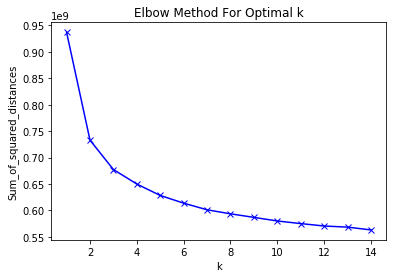

In [17]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [18]:
# choose optimal number of clusters
k_optimal = 4   

#### 1.2. Fitting the model for optimal number of clusters

In [19]:
# Calculate cluster labels for k_optimal
Kmean = KMeans(n_clusters=k_optimal)
Kmean.fit(embeddings)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [20]:
# Kmean.labels_
# Kmean.cluster_centers_

#### 1.3. Visualization of  n closest images to centroids 

In [21]:
# CHOOSE visualization parameters
# Number of closest images to show
n_of_images = 20 
# Number of images to be displayed per row and column
n_img_col = 7
n_img_row =  int(n_of_images/n_img_col) +1  

In [22]:
patches = np.array(images).squeeze()
centroids = Kmean.cluster_centers_
centroids.shape

(3, 1600)

In [23]:
closest_imgs = [] 
for i in range(centroids.shape[0]):
    d = Kmean.transform(embeddings)[:, i]
    ind = np.argsort(d)[::-1][:n_of_images]
    closest_imgs.append(patches[ind])
closest_imgs = np.array(closest_imgs)

In [24]:
# (n_clusters, closest_imgs, image_h, image_w)
closest_imgs.shape

(3, 20, 256, 256)

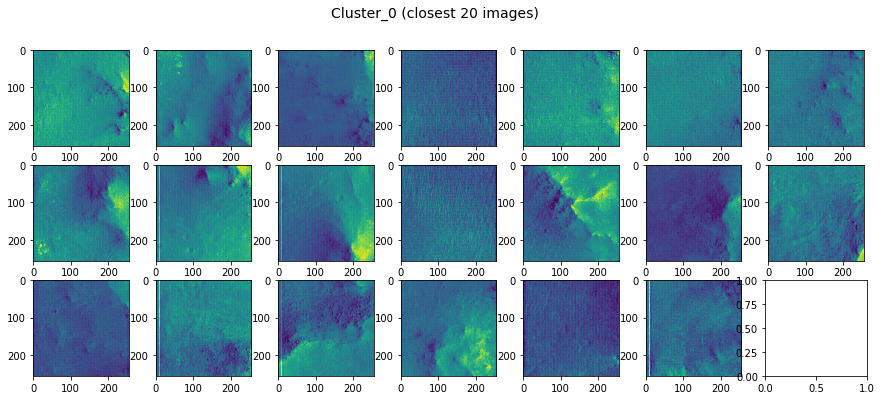

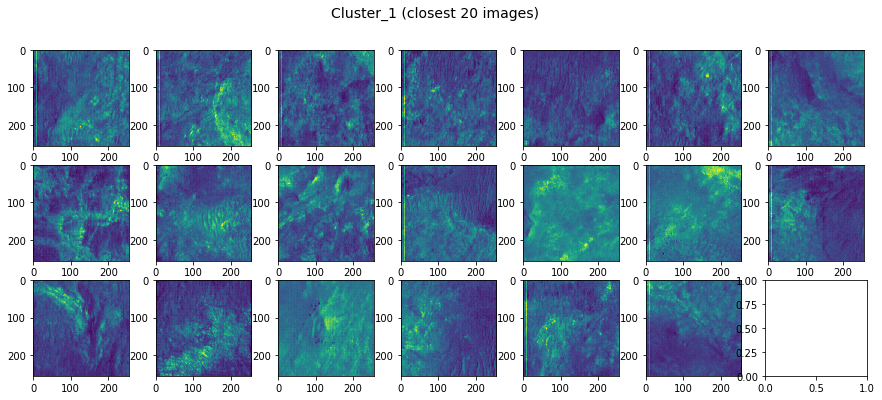

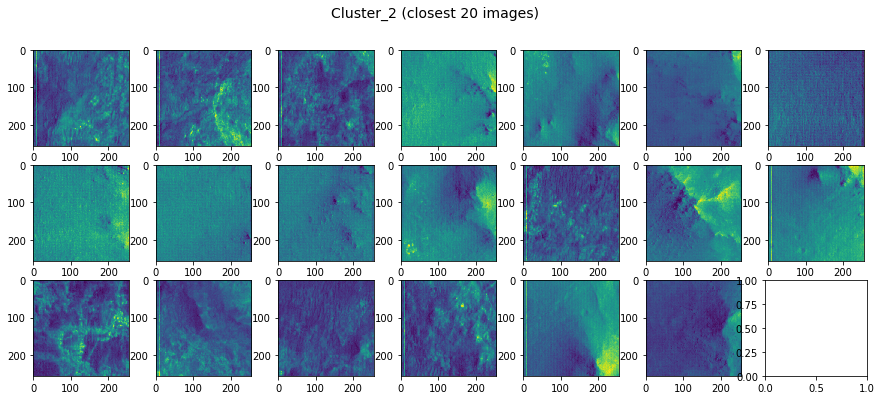

In [33]:
for i in range(0, k_optimal):
    fig,axarr = plt.subplots(n_img_row,n_img_col,figsize=(15, 6))
    fig.suptitle('Cluster_'+str(i)+' (closest '+str(n_of_images)+' images)', fontsize=14)
    for ax,im in zip(axarr.ravel(), closest_imgs[i]):
        ax.imshow(im)

## 2. DBSCAN clustering

In [25]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt

#### 2.1. Fitting the model

In [26]:
embed_scaled = StandardScaler().fit_transform(embeddings)

In [27]:
# cluster the data into clusters
dbscan = DBSCAN(eps=16, min_samples = 4)

In [28]:
model = dbscan.fit(embed_scaled)
labels = model.labels_
labels

array([-1, -1,  1, ..., -1, -1, -1], dtype=int64)

In [29]:
pd.Series(labels).value_counts()
# Label -1 means that the point was not assigned to any cluster (which is allowed in this algorithm)

-1    1495
 0      49
 1      20
dtype: int64

Performance metric

Silhouette Score: A silhouette score ranges from -1 to 1, with -1 being the worst score possible and 1 being the best score. Silhouette scores of 0 suggest overlapping clusters. The silhouette score is calculated utilizing the mean intra- cluster distance between points, AND the mean nearest-cluster distance. For instance, a cluster with a lot of data points very close to each other (high density) AND is far away from the next nearest cluster (suggesting the cluster is very unique in comparison to the next closest), will have a strong silhouette score. 

In [30]:
# Computing Silhouette Score
print('Silhouette Coefficient: %0.3f' %metrics.silhouette_score(embed_scaled,labels))

Silhouette Coefficient: -0.167


#### 2.2. Visualization of DBSCAN core points 
 In order for a point to be considered a “core” point, the point must contain the minimum number of points within epsilon distance. 

In [31]:
dbscan.core_sample_indices_.shape[0]

45

In [34]:
# CHOOSE visualization parameters
# Number of images to show
n_of_images = dbscan.core_sample_indices_.shape[0]
# Number of images to be displayed per row and column
n_img_col = 7
n_img_row =  int(n_of_images/n_img_col) +1  

In [35]:
np.array(images).shape

(1564, 256, 256, 1)

In [36]:
patches = np.array(images).squeeze()
patches_core = patches[dbscan.core_sample_indices_]
labels_core = labels[dbscan.core_sample_indices_]
print(patches_core.shape, labels_core.shape)

(45, 256, 256) (45,)


In [37]:
# Calculating the number of clusters
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

2

In [39]:
clusters_list = range(0, n_clusters_)
classes =[]
for i in clusters_list:
    classes.append (patches [np.where(labels==i)])
classes=np.array(classes)

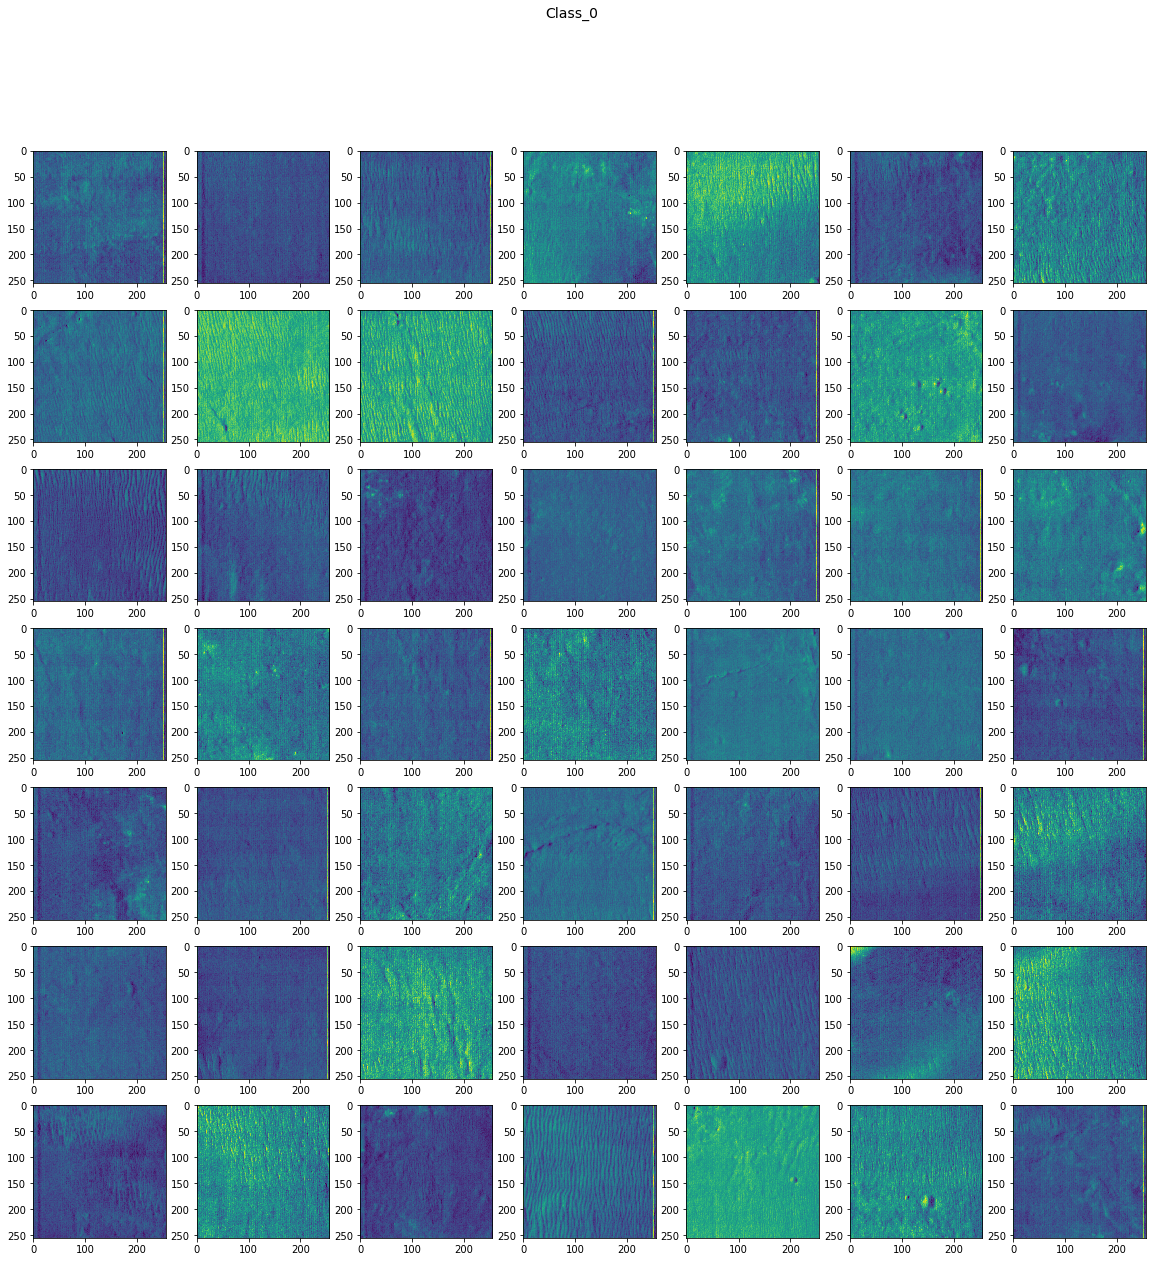

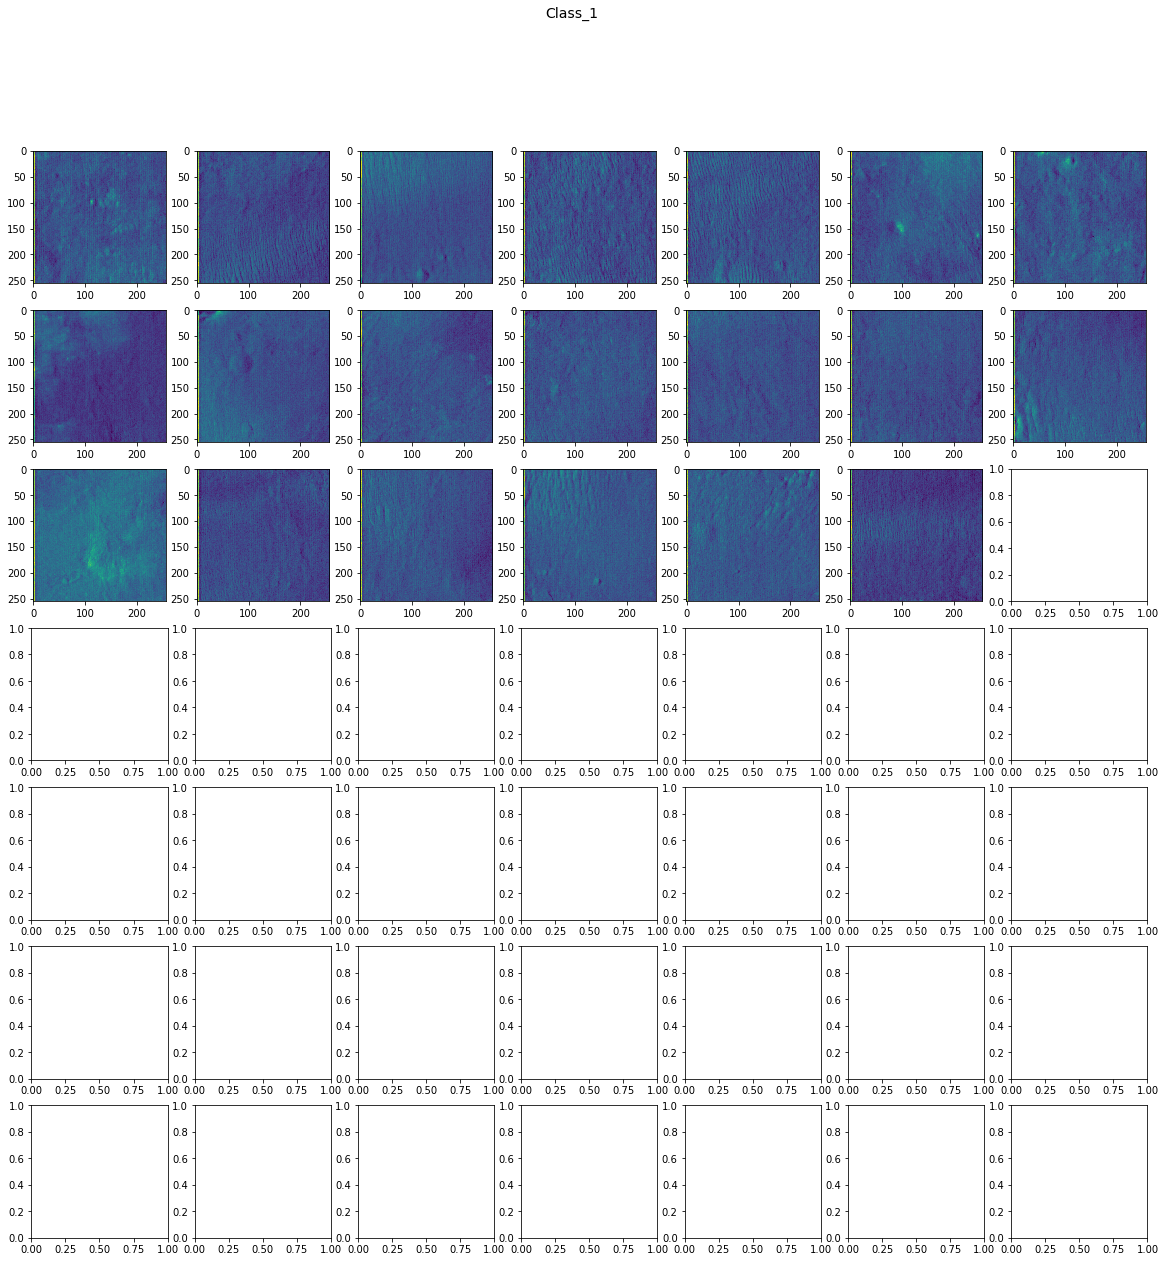

In [40]:
for i in clusters_list:
    fig,axarr = plt.subplots(n_img_row,n_img_col,figsize=(20, 20))
    fig.suptitle('Class_'+str(i), fontsize=14)
    for ax,im in zip(axarr.ravel(), classes[i]):
        ax.imshow(im)

In [41]:
# Check
print(patches [np.where(labels==0)].shape,
      patches [np.where(labels==1)].shape,
      patches [np.where(labels==2)].shape,
      patches [np.where(labels==3)].shape)

(49, 256, 256) (20, 256, 256) (0, 256, 256) (0, 256, 256)
